In [3]:
import gymnasium as gym
import mahjong_env
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from time import strftime
import csv
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
class Logger:
    def __init__(self):
        # Create a unique log directory
        self.log_dir = f"log_{strftime("%Y_%m_%d-%H_%M_%S")}"
        os.makedirs(self.log_dir, exist_ok=True)

        # Paths for logging files
        self.rewards_log_path = os.path.join(self.log_dir, "rewards.csv")
        self.transitions_log_path = os.path.join(self.log_dir, "transitions.csv")
        self.evaluation_log_path = os.path.join(self.log_dir, "evaluation_rewards.csv")
        self.policy_model_path = os.path.join(self.log_dir, "policy_model.keras")
        self.value_model_path = os.path.join(self.log_dir, "value_model.keras")

        # Initialize the CSV log files
        with open(self.rewards_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward sum", "last reward", "steps"])

        with open(self.transitions_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "state", "action", "next-state", "reward", "done", "truncated"])

        with open(self.evaluation_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward_sum", "last_reward", "steps"])

    def log_training_reward(self, episode, reward_sum, last_reward, steps):
        with open(self.rewards_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, reward_sum, last_reward, steps])
            
    def log_eval_reward(self, episode, reward_sum, last_reward, steps):
        with open(self.rewards_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, reward_sum, last_reward, steps])

    def log_transition(self, episode, state, action, next_state, reward, done, truncated):
        with open(self.transitions_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, state.tolist(), action, next_state.tolist(), reward, done, truncated])

    def save_policy_model(self, model):
        model.save(self.policy_model_path)
        
    def save_value_model(self, model):
        model.save(self.value_model_path)


class RewardNormalizer:
    def __init__(self):
        self.mean = 0
        self.var = 0
        self.count = 0

    def normalize(self, reward):
        self.count += 1
        old_mean = self.mean
        self.mean += (reward - self.mean) / self.count
        self.var += (reward - old_mean) * (reward - self.mean)
        std = (self.var / self.count) ** 0.5
        return (reward - self.mean) / (std + 1e-8)


class ActorCritic:
    def __init__(self, env, policy_network, value_network, logger, gamma=0.99):
        self.env = env
        self.policy_network = policy_network
        self.value_network = value_network
        self.gamma = gamma
        self.learning_rate = 0.001
        self.policy_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.value_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.training_rewards_per_episode_sum = []
        self.training_rewards_per_episode_last_one = []
        self.eval_rewards_per_episode_sum = []
        self.eval_rewards_per_episode_last_one = []
        self.logger = logger
        self.reward_normalizer = RewardNormalizer()


    def take_action(self, state):
        action_probs = self.policy_network(state[np.newaxis]).numpy()[0]
        action_probs[(state[:27]==0)] = -np.inf
        action = np.argmax(action_probs)
        return action
    
    
    
    def sample_action(self, state):
        action_probs = self.policy_network(state[np.newaxis]).numpy()[0]
        valid_actions = np.where(state[:27] != 0)[0]
        invalid_actions = np.where(state[:27] == 0)[0]
        action_probs[invalid_actions] = 0.0
        total_prob = np.sum(action_probs)
        if total_prob == 0.0:
            print("No valid actions")
            return np.random.choice(valid_actions)

        # Create normalized probabilities only for valid actions
        normalized_probs = np.zeros_like(action_probs)
        normalized_probs[valid_actions] = action_probs[valid_actions] / total_prob

        # Sample an action using normalized probabilities
        action = np.random.choice(range(len(normalized_probs)), p=normalized_probs)
        return action

    
    def train_step(self, state, action, reward, next_state, done):
        # Compute target Q-value
        with tf.GradientTape() as value_tape:
            q_value = tf.squeeze(self.value_network(tf.expand_dims(state, axis=0)), axis=-1)
            target_q_value = reward + self.gamma * tf.squeeze(self.value_network(tf.expand_dims(next_state, axis=0)), axis=-1) * (1 - done)
            value_loss = tf.keras.losses.Huber()(target_q_value, q_value)
    
        # Update value network
        value_grads = value_tape.gradient(value_loss, self.value_network.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_network.trainable_variables))
    
        # Compute policy loss using TD error
        td_error = target_q_value - q_value
        with tf.GradientTape() as policy_tape:
            action_probs = self.policy_network(tf.expand_dims(state, axis=0))
            mask = tf.constant(state[:27] != 0, dtype=tf.float32)
            masked_action_probs = action_probs * mask
            masked_action_probs /= (tf.reduce_sum(masked_action_probs) + 1e-8)
            selected_action_prob = tf.gather_nd(masked_action_probs, [[0, action]])
            selected_action_prob = tf.maximum(selected_action_prob, 1e-8)
            policy_loss = -tf.reduce_mean(tf.math.log(selected_action_prob) * tf.stop_gradient(td_error))
    
        # Update policy network
        policy_grads = policy_tape.gradient(policy_loss, self.policy_network.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_network.trainable_variables))


    def process_state(self, state):
        normalized_hand = state['hand'] / 4.0
        normalized_visible_cards = state['visible cards'] / 4.0
        kangs_one_hot = tf.one_hot(state['kangs'], depth=4).numpy()
        kangs_one_hot_flat = kangs_one_hot.reshape(-1)
        final_array = np.concatenate((
            normalized_hand,
            state['pongs'],
            kangs_one_hot_flat,
            normalized_visible_cards
        ))
        return final_array
    
    
    def run_episode(self):
        state, _ = self.env.reset()
        state = self.process_state(state)
        episode_reward = 0
        done = False
        steps = 0
        last_reward = 0
        while not done:
            action = self.sample_action(state)
            next_state, reward, done, truncated, _ = self.env.step(action)
            next_state = self.process_state(next_state)
            done = done or truncated
            normalized_reward = self.reward_normalizer.normalize(reward)
            self.train_step(state, action, normalized_reward, next_state, done)
            steps += 1
            episode_reward += reward
            if done:
                last_reward = reward
            state = next_state

        return episode_reward, last_reward, steps
    
    def evaluate(self, episodes):
        for episode in range(episodes):
            state, _ = self.env.reset()
            state = self.process_state(state)
            episode_reward = 0
            done = False
            steps = 0
            last_reward = 0
            while not done:
                action = self.take_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = self.process_state(next_state)
                done = done or truncated
                steps += 1
                episode_reward += reward
                if done:
                    last_reward = reward
                state = next_state
            self.eval_rewards_per_episode_sum.append(episode_reward)
            self.eval_rewards_per_episode_last_one.append(last_reward)
            if self.logger:
                self.logger.log_eval_reward(episode, episode_reward, last_reward, steps)
            print(f"Episode {episode + 1}: Reward sum = {episode_reward:.2f}, Last reward = {last_reward}, Steps = {steps}")


    def train(self, episodes=1, save_freq=20):
        for episode in range(episodes):
            episode_reward, last_reward, steps = self.run_episode()
            self.training_rewards_per_episode_sum.append(episode_reward)
            self.training_rewards_per_episode_last_one.append(last_reward)
            if self.logger:
                self.logger.log_training_reward(episode, episode_reward, last_reward, steps)
            print(f"Episode {episode + 1}: Reward sum = {episode_reward:.2f}, Last reward = {last_reward}, Steps = {steps}")
            if (episode + 1) % save_freq == 0 and self.logger:
                self.logger.save_policy_model(self.policy_network)
                self.logger.save_value_model(self.value_network)


class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(PolicyNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(64, activation='relu')
        self.dense4 = tf.keras.layers.Dense(num_actions, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return x


class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, state):
        x = self.dense1(state)
        return self.dense3(self.dense2(x))


def plot_rewards(root_folder, rewards, title, save_fig=False):
    plt.figure(figsize=(12, 8))
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(title)
    plt.grid(True)
    if save_fig:
        plt.savefig(root_folder + "/" + title + '_' + strftime("%Y_%m_%d_%H_%M_%S") +'_' + '.png')
    plt.legend()
    plt.show()
    
    

In [5]:
# Environment setup
env = gym.make("Mahjong-v2")
policy = PolicyNetwork(num_actions=27)
value_network = ValueNetwork()
logger = Logger()
agent = ActorCritic(env, policy, value_network, logger)
agent.train(10000)


2024-12-10 18:05:55.309940: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 1: Reward sum = -24.22, Last reward = -25.0, Steps = 15
Episode 2: Reward sum = -4.32, Last reward = -5.0, Steps = 8
Episode 3: Reward sum = -18.95, Last reward = -20.0, Steps = 13
Episode 4: Reward sum = -22.95, Last reward = -25.0, Steps = 16
Episode 5: Reward sum = -1.79, Last reward = -5.0, Steps = 17
Episode 6: Reward sum = -3.21, Last reward = -5.0, Steps = 15
Episode 7: Reward sum = -3.04, Last reward = -5.0, Steps = 13
Episode 8: Reward sum = -17.81, Last reward = -20.0, Steps = 16
Episode 9: Reward sum = -60.40, Last reward = -63.0, Steps = 15
Episode 10: Reward sum = -78.73, Last reward = -80.0, Steps = 15
Episode 11: Reward sum = -3.17, Last reward = -5.0, Steps = 16
Episode 12: Reward sum = -28.69, Last reward = -30.0, Steps = 11
Episode 13: Reward sum = -6.72, Last reward = -8.0, Steps = 7
Episode 14: Reward sum = -28.72, Last reward = -30.0, Steps = 17
Episode 15: Reward sum = -37.98, Last reward = -40.0, Steps = 16
Episode 16: Reward sum = -4.28, Last reward = -5

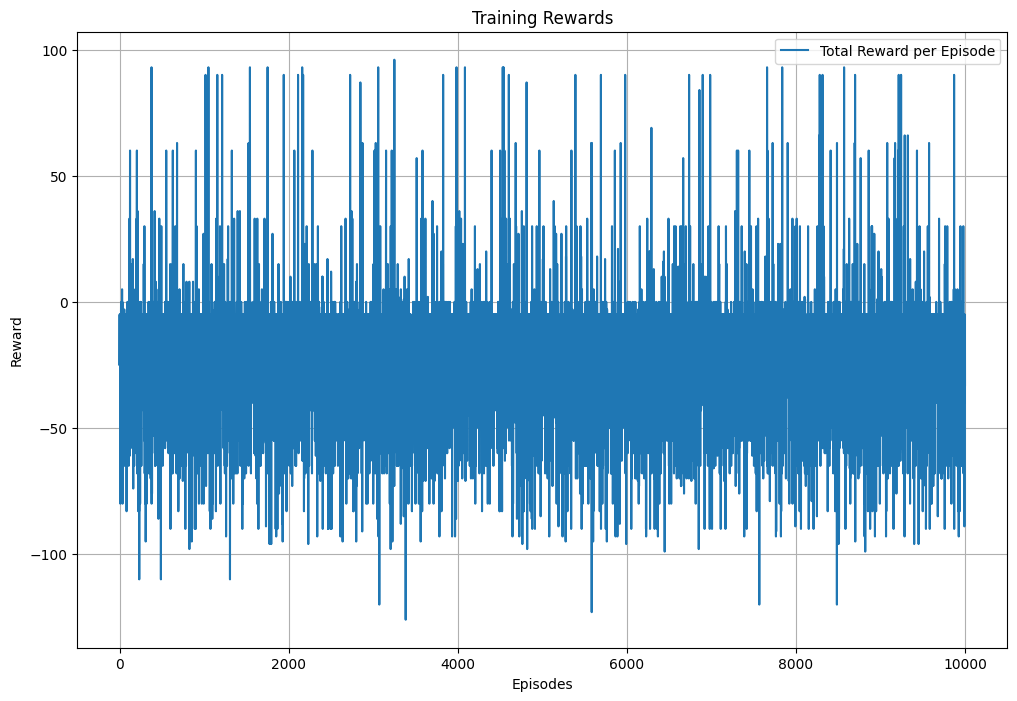

Mean =  -20.7676


In [6]:
plot_rewards(logger.log_dir, agent.training_rewards_per_episode_last_one, title="Training Rewards", save_fig=True)
print("Mean = ", np.mean(agent.training_rewards_per_episode_last_one))

In [7]:
agent_eval = ActorCritic(env, policy, value_network, logger)
agent_eval.evaluate(1000)


Episode 1: Reward sum = -2.72, Last reward = -5.0, Steps = 12
Episode 2: Reward sum = -22.25, Last reward = -23.0, Steps = 11
Episode 3: Reward sum = -37.01, Last reward = -38.0, Steps = 15
Episode 4: Reward sum = -35.87, Last reward = -38.0, Steps = 18
Episode 5: Reward sum = 22.39, Last reward = 20.0, Steps = 16
Episode 6: Reward sum = -3.10, Last reward = -5.0, Steps = 13
Episode 7: Reward sum = -2.07, Last reward = -5.0, Steps = 15
Episode 8: Reward sum = -11.27, Last reward = -13.0, Steps = 16
Episode 9: Reward sum = -32.57, Last reward = -35.0, Steps = 17
Episode 10: Reward sum = -2.57, Last reward = -5.0, Steps = 17
Episode 11: Reward sum = -7.48, Last reward = -10.0, Steps = 15
Episode 12: Reward sum = -3.37, Last reward = -5.0, Steps = 11
Episode 13: Reward sum = -29.34, Last reward = -30.0, Steps = 17
Episode 14: Reward sum = -29.18, Last reward = -30.0, Steps = 16
Episode 15: Reward sum = -3.28, Last reward = -5.0, Steps = 10
Episode 16: Reward sum = -2.90, Last reward = -5.

Mean =  -16.69


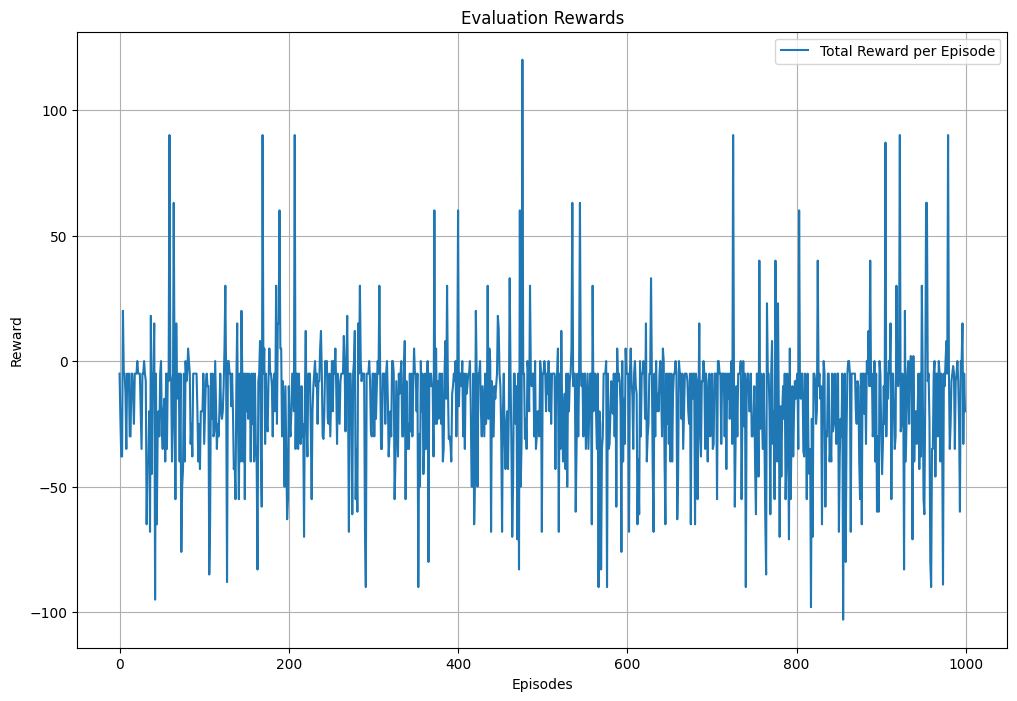

In [8]:
print("Mean = ", np.mean(agent_eval.eval_rewards_per_episode_last_one))
plot_rewards(logger.log_dir, agent_eval.eval_rewards_per_episode_last_one, title="Evaluation Rewards", save_fig=True)
